In [1]:
import sys

import polars as pl
import torch

from data_loader.TimeSeriesModule import MultiPartDataModule
from training.config import TrainingConfig
from training.model_trainers.total_train import run_total_train_monthly
from utils.checkpoint import save_model_dict, load_model_dict
from utils.plot_utils import plot_val_per_part, plot_120_months_many

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = '../data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.version.cuda)
    print(torch.__version__)
    print(torch.cuda.get_device_name(0))
    print(torch.__version__)
else:
    DIR = MAC_DIR

True
1
12.8
2.9.0.dev20250716+cu128
NVIDIA GeForce RTX 5080
2.9.0.dev20250716+cu128


In [2]:
target_dyn_demand_monthly = pl.read_parquet(DIR + 'target_dyn_demand_monthly.parquet')

In [3]:
plan_yyyymm = 202305

train_cfg = TrainingConfig()

data_module = MultiPartDataModule(
    target_dyn_demand_monthly,
    train_cfg,
    batch_size = 64,
    val_ratio = 0.2,
    is_running = False
)
train_loader = data_module.get_train_loader()
val_loader = data_module.get_val_loader()

In [4]:
model_dict = run_total_train_monthly(train_loader, val_loader)

C:\Users\USER\python\py312\Lib\site-packages\torch\nn\modules\conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1028.)
  return F.conv1d(


Epoch 1/1 | LR 0.000976 | Train 55.910059 | Val 61.215295
Epoch 1/1 | LR 0.000976 | Train 48.891387 | Val 52.755225
Epoch 1/1 | LR 0.000976 | Train 204.819097 | Val 210.305094
Epoch 1/1 | LR 0.000976 | Train 203.919228 | Val 208.654568
Epoch 1/1 | LR 0.000976 | Train 201.669857 | Val 209.229245
Epoch 1/1 | LR 0.000976 | Train 37.476607 | Val 38.498809


In [5]:
model_dict

{'PatchMixer Base': PatchMixerModel(
   (backbone): PatchMixerBackbone(
     (padding_patch_layer): ReplicationPad1d((0, 8))
     (PatchMixer_blocks): ModuleList(
       (0-1): 2 x PatchMixerLayer(
         (token_mixer): Sequential(
           (0): Conv1d(4, 4, kernel_size=(8,), stride=(1,), padding=same, groups=4)
           (1): GELU(approximate='none')
           (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         )
         (channel_mixer): Sequential(
           (0): Conv1d(4, 4, kernel_size=(1,), stride=(1,))
           (1): GELU(approximate='none')
           (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         )
         (dropout): Dropout(p=0.1, inplace=False)
       )
     )
     (W_P): Linear(in_features=16, out_features=16, bias=True)
     (revin_layer): RevIN()
     (flatten): Flatten(start_dim=-2, end_dim=-1)
   )
   (proj): Sequential(
     (0): Linear(in_features=64, out_features=128, bias

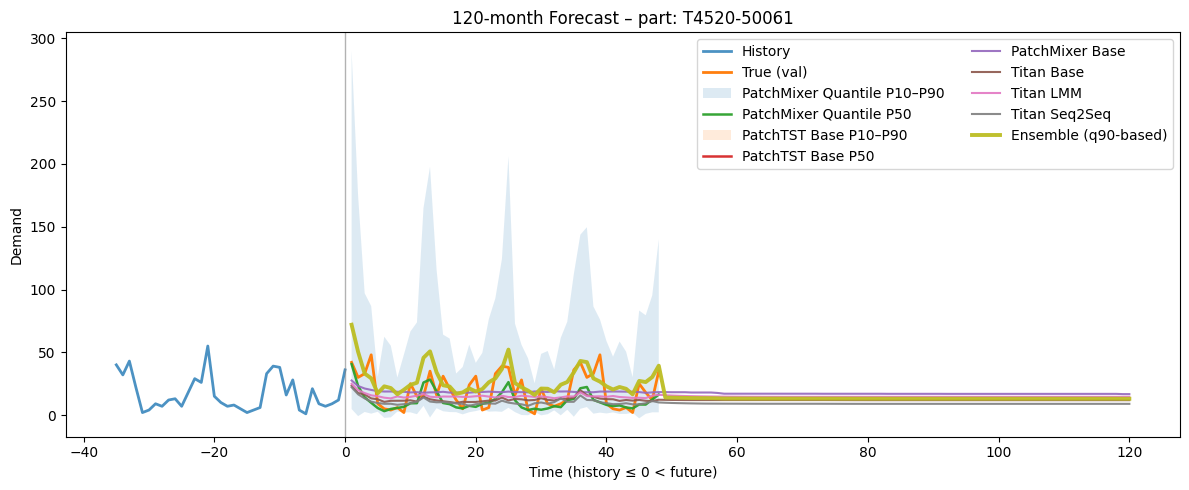

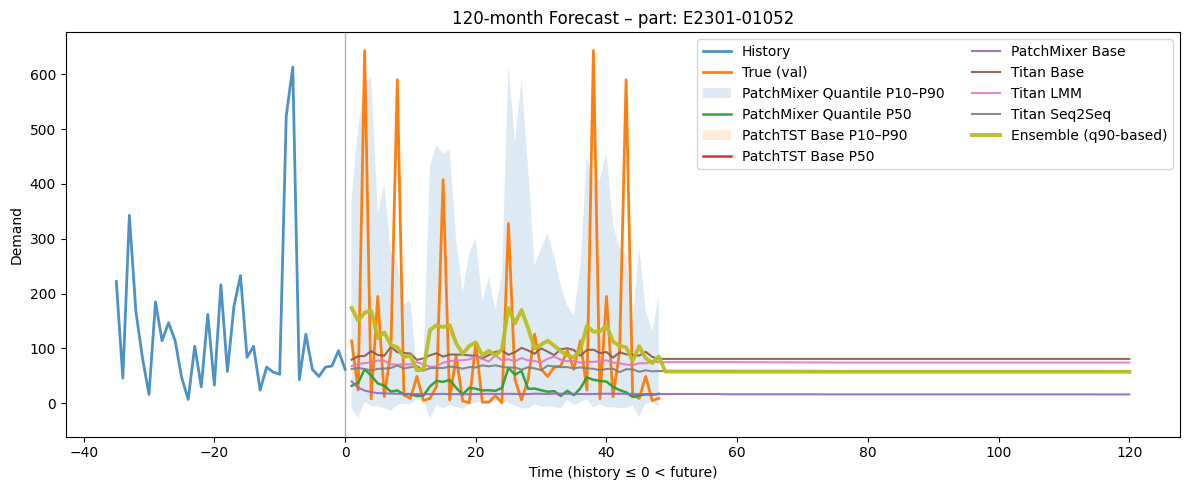

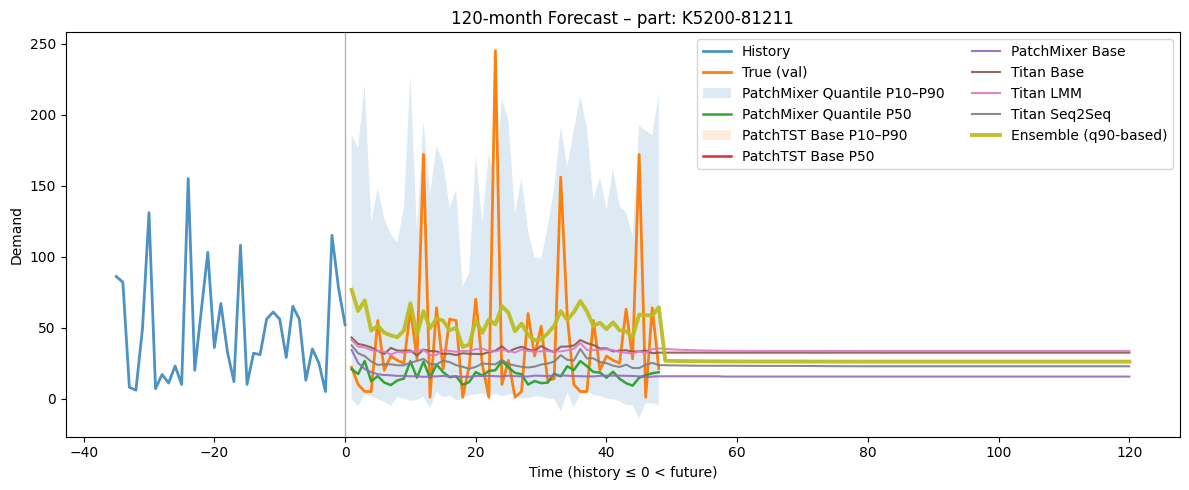

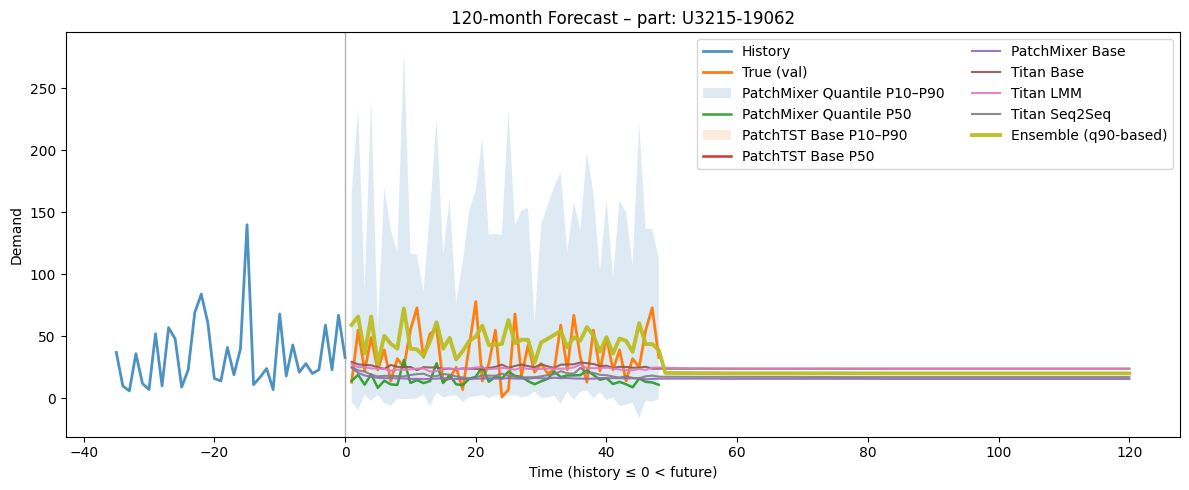

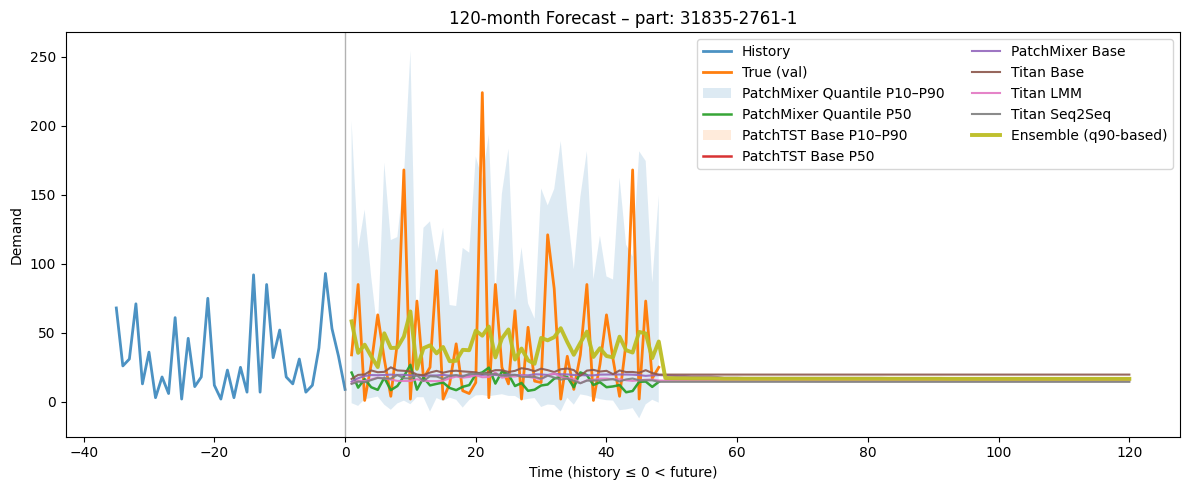

In [6]:
from models.PatchTST.common.configs import PatchTSTConfigMonthly
from models.Titan.common.configs import TitanConfigMonthly
from models.PatchMixer.common.configs import PatchMixerConfigMonthly

save_dir = DIR + 'fit'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

pm_config = PatchMixerConfigMonthly(
        device = device,
        loss_mode = 'quantile',
        quantiles = (0.1, 0.5, 0.9)
    )

ti_config = TitanConfigMonthly(
        device = device,
        loss_mode = 'point',
        point_loss = 'huber'
    )

pt_config = PatchTSTConfigMonthly(
        device = device,
        loss_mode = 'auto',
        quantiles = (0.1, 0.5, 0.9)
    )

cfg_map = {
    "PatchMixer Base": pm_config,
    "PatchMixer Quantile": pm_config,
    "Titan Base": ti_config,
    "Titan LMM": ti_config,
    "Titan Seq2Seq": ti_config,
    "PatchTST Base": pt_config
}

builder_key_by_name = {
  "PatchMixer Base": "patchmixer_base",
  "PatchMixer Quantile": "patchmixer_quantile",
  "Titan Base": "titan_base",
  "Titan LMM": "titan_lmm",
  "Titan Seq2Seq": "titan_seq2seq",
  "PatchTST Base": "patchtst_base",
}
save_index = save_model_dict(model_dict, save_dir, cfg_by_name = cfg_map, builder_key_by_name=builder_key_by_name)

# Load
from models.model_builder import (
    build_patch_mixer_base, build_patch_mixer_quantile,
    build_titan_base, build_titan_lmm, build_titan_seq2seq,
    build_patchTST_base
)

builders = {
    "patchmixer_base": lambda cfg: build_patch_mixer_base(cfg or PatchMixerConfigMonthly()),
    "patchmixer_quantile": lambda cfg: build_patch_mixer_quantile(cfg or PatchMixerConfigMonthly()),
    "titan_base": lambda cfg: build_titan_base(cfg or TitanConfigMonthly()),
    "titan_lmm": lambda cfg: build_titan_lmm(cfg or TitanConfigMonthly()),
    "titan_seq2seq": lambda cfg: build_titan_seq2seq(cfg or TitanConfigMonthly()),
    "patchtst_base": lambda cfg: build_patchTST_base(cfg or PatchTSTConfigMonthly()),
}
loaded = load_model_dict(save_dir, builders, device = device)

plot_out = DIR + 'plot'
plot_120_months_many(loaded, val_loader, device=device, use_truth=True,
                     max_plots=5, show=True)